In [9]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time


In [10]:
ROOT_DIR = (Path('..')).resolve()
assert(ROOT_DIR.resolve().exists())

EXPERIMENTS_DIR = ROOT_DIR / 'experiments'
LOGS_DIR = EXPERIMENTS_DIR / 'logs'
assert(LOGS_DIR.exists()), f"Logs directory {LOGS_DIR} does not exist!"

In [11]:
def calc_ylims(ax, step=0.1):
    y_min, y_max = ax.get_ylim()
    
    y_max = np.ceil(y_max / step) * step

    ax.set_ylim(0, y_max)

In [12]:
def plot_history(df, hide_metrics):
    """
    Plots training progress live from the CSVLogger output.
    Losses are plotted together, each metric is plotted individually.
    """

    if hide_metrics is None:
        hide_metrics = []
    if not all(m in df.columns for m in hide_metrics):
        print(f"Hiding metrics: {hide_metrics}")
        print(df.columns)
        raise ValueError(f"hide_metrics contains invalid metric names: {hide_metrics}")
    
    metric_cols = set(df.columns) - {'epoch', 'train_loss', 'valid_loss', 'time'} - set(hide_metrics)
    if len(df) > 0:
        clear_output(wait=True)
        n_metrics = len(metric_cols)
        fig, axes = plt.subplots(1, 1 + n_metrics, figsize=(7*(1 + n_metrics), 5))

        if n_metrics == 0:
            axes = [axes]
        else:
            axes = np.atleast_1d(axes)

        # Plot 1: Losses
        df[['train_loss', 'valid_loss']].plot(ax=axes[0])
        axes[0].set_title('Training & Validation Loss')
        axes[0].set_xlabel('Epoch')
        # axes[0].set_yscale('log')
        axes[0].grid(True)

        # Plot each metric individually
        for i, metric in enumerate(sorted(metric_cols), start=1):
            df[metric].plot(ax=axes[i], alpha=0.5, color='tab:orange', label='Raw')
            df[metric].rolling(window=5, min_periods=1).mean().plot(ax=axes[i], color='tab:orange', label='Smoothed')
            axes[i].set_title(metric)
            axes[i].set_xlabel('Epoch')
            axes[i].grid(True)

            # Scatter new bests
            best_idxs = df[metric].cummax().diff().fillna(0) > 0
            best_epochs = df.index[best_idxs]
            axes[i].scatter(best_epochs, df.loc[best_epochs, metric], color='tab:orange', label='New Best', zorder=5, alpha=0.7, marker='x')
            axes[i].legend()

            # vline with text of current epoch
            current_epoch = df['epoch'].iloc[-1]
            axes[i].axvline(current_epoch, color='gray', linestyle='--', alpha=0.7)
            axes[i].text(current_epoch, axes[i].get_ylim()[1]*0.95, f'Epoch {current_epoch}', rotation=90, verticalalignment='top', color='gray')
            
            calc_ylims(axes[i], step=0.05)

        plt.tight_layout()
        plt.show()

In [13]:
def monitor_training(csv_path='history.csv', interval_ms=500, hide_metrics=None):
    """
    Plots training progress live from the CSVLogger output.
    Losses are plotted together, each metric is plotted individually.
    Scatter a point on each new best validation loss.
    """
    last_df = None
    while True:

        try:
            df = pd.read_csv(csv_path)
            if last_df is None or not df.equals(last_df):
                plot_history(df, hide_metrics=hide_metrics)
                
            last_df = df
            
        except FileNotFoundError:
            print("Waiting for CSVLogger to create history.csv...")
        except Exception as e:
            print(f"Error reading log: {e}")
            
        time.sleep(interval_ms / 1000)

In [14]:
# monitor_training(LOGS_DIR / 'segmentation_log.csv', hide_metrics=['dice_multi'], interval_ms=2*1000)

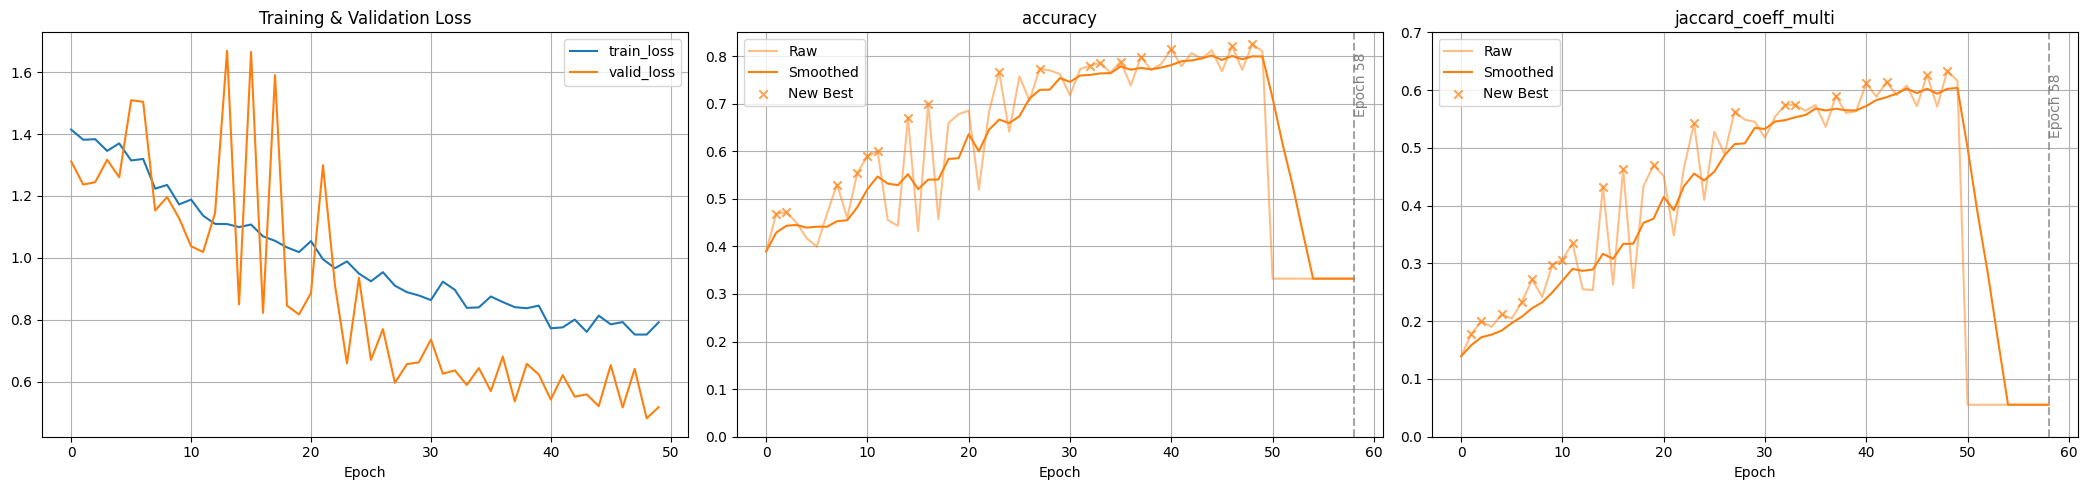

In [15]:
df = pd.read_csv(LOGS_DIR / 'baseline_log.csv',)
plot_history(df, hide_metrics=['dice_multi'])

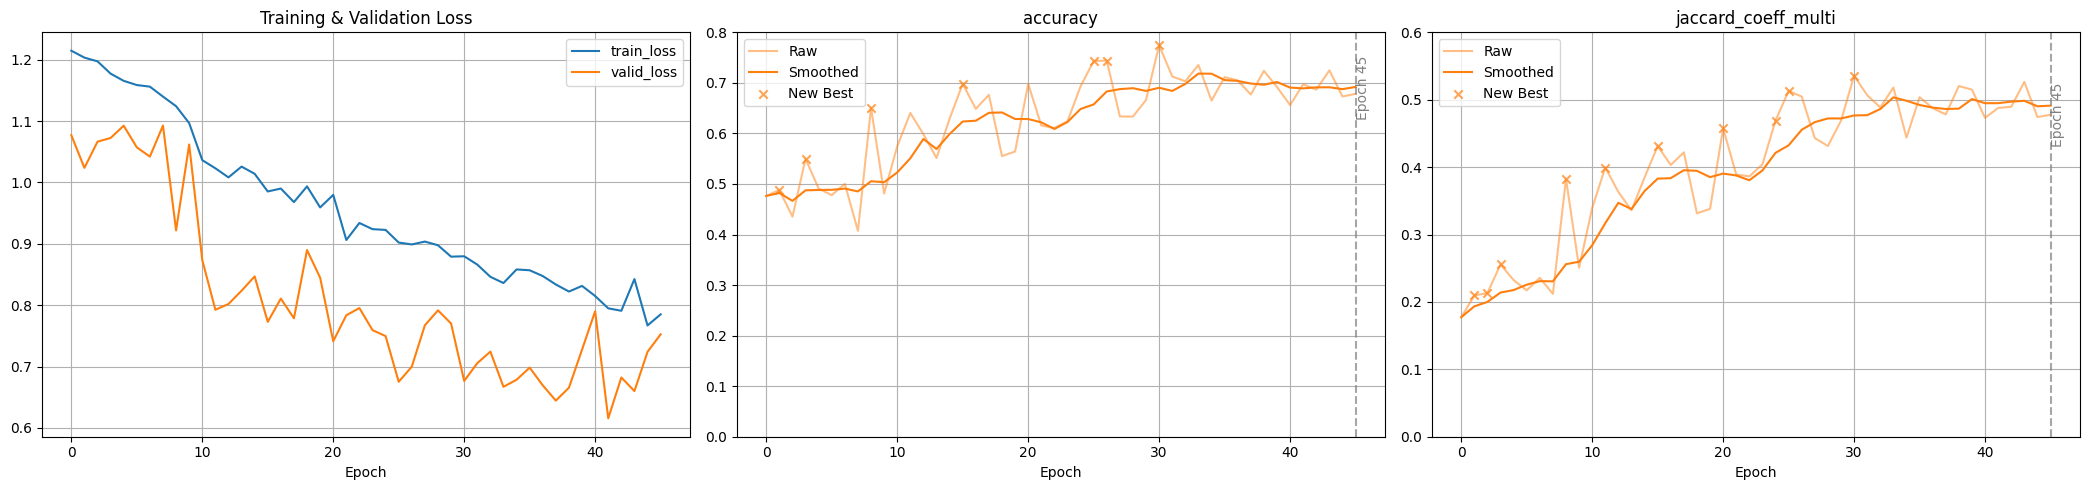

In [16]:
df = pd.read_csv(LOGS_DIR / 'cse_combined_loss_log.csv',)
plot_history(df, hide_metrics=['dice_multi'])

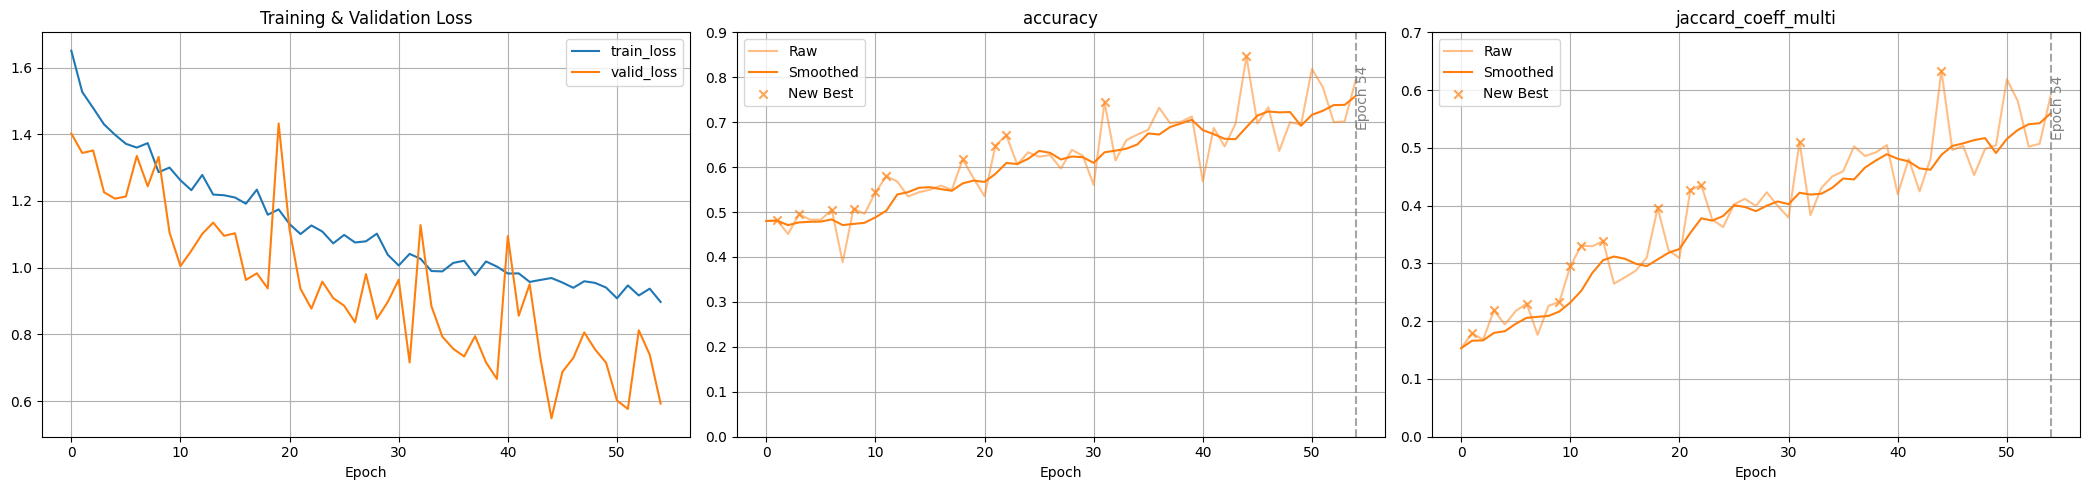

In [17]:
df = pd.read_csv(LOGS_DIR / 'cse_log.csv',)
plot_history(df, hide_metrics=['dice_multi'])